# Assessing the precision of the Karhunen-Loeve method

We will work in the case of a one-dimensional process, but the results should be scalable to higher-dimensional processes.

In [149]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [150]:
#let's create a grid and define a covariance model
# We choose the matern model as it is frequently used to model stochastic fields
grid = ot.RegularGrid(0,1,100)
covaModel10_ = ot.MaternModel([10.], [1.],0.5)
process = ot.GaussianProcess(covariance_model, grid)

In this notebook we will not explore all the existing covariance models, only the Matern model which is widely used.
We will look at the effect of the different parameters controlling this model, as well as their effect on a subsequent Karhunen Loeve decomposition.
The three parameters controlling the Matern Model are the amplitude, scale and nu parameter.
The amplitude controlls the amplitude of the stochastic process:

In [151]:
amplitudes = [1,5,10,20,50]
samples = []
for amp in amplitudes:
    cova_model = ot.MaternModel([10.], [float(amp)],0.5)
    process = ot.GaussianProcess(cova_model, grid)
    procSample = process.getSample(5000)
    array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
    mean = array.mean(axis=1).mean()
    std = array.std(axis=1).mean()
    samples.append(sample)
    print('Mean: {}, StandDev: {} '.format(round(mean,4),str(round(std,4))))

Mean: -0.0011, StandDev: 0.8913 
Mean: 0.0048, StandDev: 4.4416 
Mean: 0.0494, StandDev: 8.9114 
Mean: -0.0154, StandDev: 17.6709 
Mean: -0.286, StandDev: 44.3858 


We correctly retrieve a value near to the value of the amplitude of the Matern Model, by calculating the intrinsic standard deviation in each field and taking the global mean.

Now let's check the influence of the scale and nu parameter on the mean and standard deviation of a process with fixed amplitude.

In [152]:
amp = [10]
scales = [1,10,20,50,75]
nus = [0.2,0.4,1,3,5,10,20]
samples_2 = []
for i in range(10):
    scale = np.random.choice(scales)
    nu = np.random.choice(nus)
    cova_model = ot.MaternModel([scale], amp,nu)
    process = ot.GaussianProcess(cova_model, grid)
    procSample = process.getSample(10000)
    array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
    mean = array.mean(axis=1).mean()
    std = array.std(axis=1).mean()
    samples.append(sample)
    print('For nu:{} , scale:{}'.format(nu,scale))
    print('    Mean: {}, StandDev: {} '.format(round(mean,4),str(round(std,4))))

For nu:20.0 , scale:10
    Mean: 0.0588, StandDev: 8.4141 
For nu:20.0 , scale:10
    Mean: 0.0309, StandDev: 8.3629 
For nu:0.4 , scale:20
    Mean: -0.0203, StandDev: 8.0907 
For nu:10.0 , scale:20
    Mean: -0.0378, StandDev: 7.053 
For nu:0.2 , scale:50
    Mean: 0.0607, StandDev: 7.5235 
For nu:0.2 , scale:20
    Mean: -0.0242, StandDev: 8.5949 
For nu:0.2 , scale:20
    Mean: 0.0519, StandDev: 8.5533 
For nu:20.0 , scale:10
    Mean: -0.0733, StandDev: 8.3857 
For nu:1.0 , scale:1
    Mean: -0.0007, StandDev: 9.8435 
For nu:0.2 , scale:10
    Mean: 0.0391, StandDev: 9.185 


We can observe variation in the values of the standard deviation. This means there is interaction between the scale, the amplitude and the nu parameter, on the scope of values the field takes. 
Let's plot the variation of the standard deviation in regard to the scale. Values normalized of course.

In [178]:
def getMeanPeakValue(array):
    peaks = []
    for rea in array : 
        argPeak = find_peaks(rea, prominence = [0.3, None])
        n_peaks = len(argPeak[0])
        peaks.append(n_peaks)
    peaks = np.array(peaks)
    mean_peak_val = peaks.mean()
    return mean_peak_val

amp = [10]
nus = [0.2,0.5,0.8,1,1.15,1.5,3,6,8,12,15,30,50]
scales = [0.5,1,5,10,20,25,50,75,100,150,200,300]
scaleNormed = np.array(scales)/100
scale_nu_stds = np.zeros([len(nus),len(scales)])
scale_nu_stds_inter = np.zeros([len(nus),len(scales)])
mean_peak_vals = np.zeros([len(nus),len(scales)])
for p, nu in enumerate(nus) :
    stds_nu = []
    stds_inter = []
    mean_peaks = []
    for scale in scales:
        cova_model = ot.MaternModel([scale], amp,nu)
        process = ot.GaussianProcess(cova_model, grid)
        procSample = process.getSample(1000)
        array = np.array(ot.Sample([procSample.getField(i).getValues().asPoint() for i in range(procSample.getSize())]))
        mean_peak_val = getMeanPeakValue(array)
        mean_peaks.append(mean_peak_val)
        std_intra = array.std(axis=1).mean()
        std_inter = array.std(axis=0).mean()
        stds_nu.append(std_intra)
        stds_inter.append(std_inter)
    stds_nu = np.array(stds_nu)
    stds_nuNormed = stds_nu/10
    stds_inter = np.array(stds_inter)/10
    scale_nu_stds[p, ...] = stds_nuNormed
    scale_nu_stds_inter[p,...] = stds_inter
    mean_peak_vals[p, ...] = mean_peaks


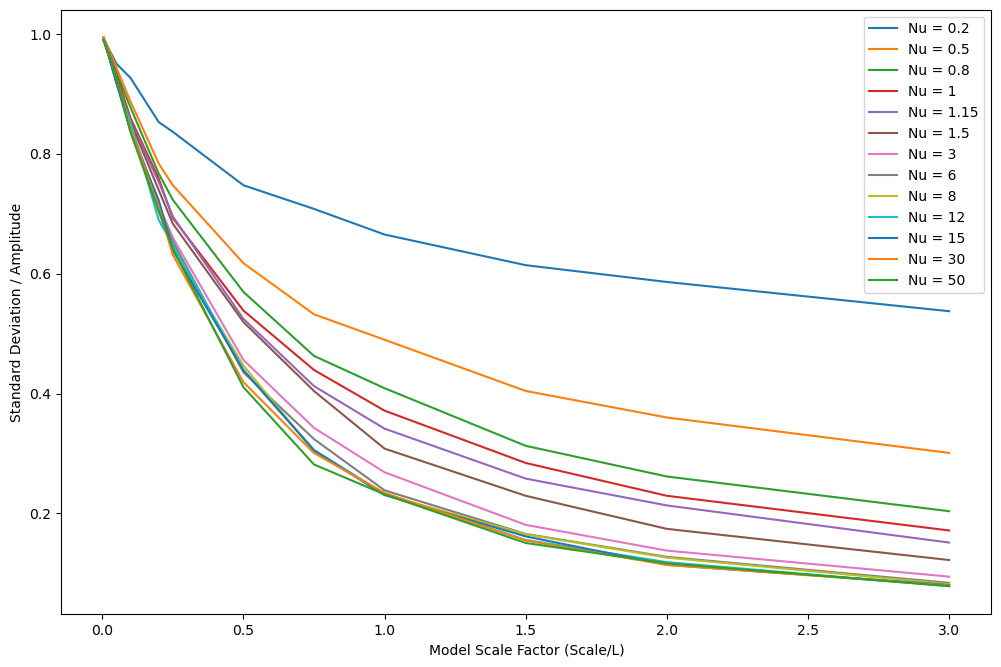

In [179]:
fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(scale_nu_stds.shape[0]):
    line = ax.plot(scaleNormed, scale_nu_stds[i],label='Nu = {}'.format(str(nus[i])))
leg=plt.legend()
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Standard Deviation / Amplitude")

Now that we have seen the effect of the scale and nu parameter on the effective standard deviation of the stochastic process, we should introduce an other parameter for measuring the process. 

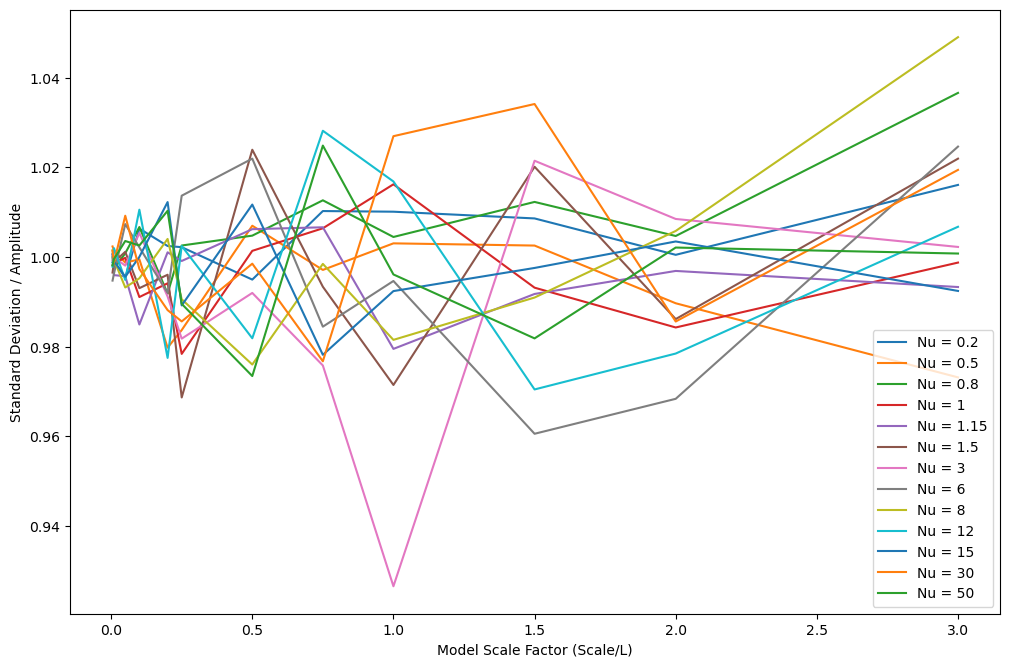

In [180]:
fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(scale_nu_stds.shape[0]):
    line = ax.plot(scaleNormed, scale_nu_stds_inter[i],label='Nu = {}'.format(str(nus[i])))
leg=plt.legend()
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Standard Deviation / Amplitude")

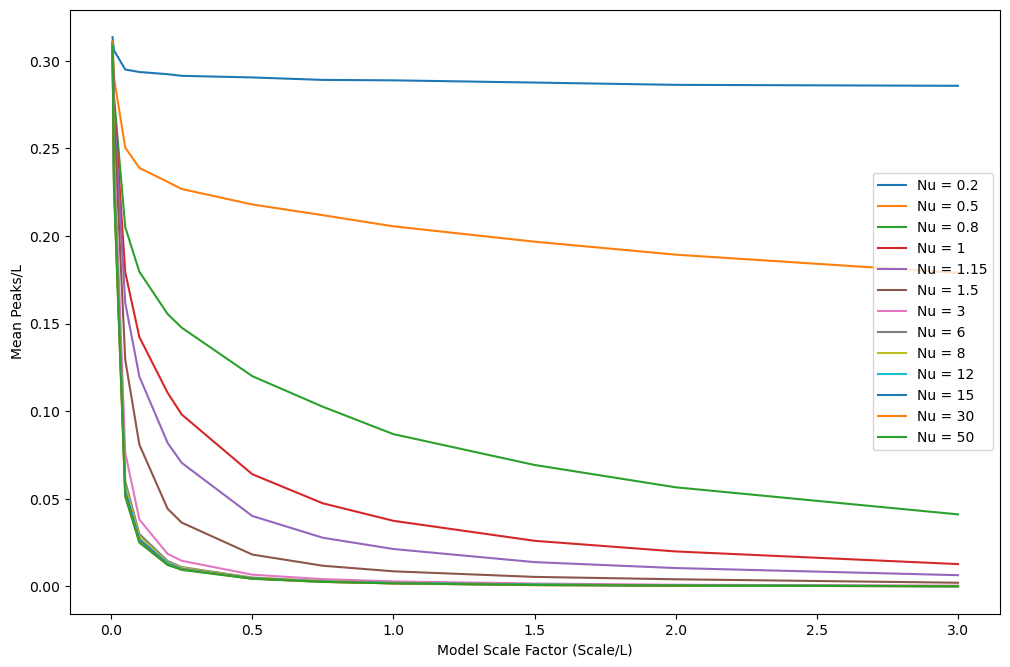

In [182]:
fig, ax= plt.subplots(figsize=(12,8), dpi= 100)
for i in range(scale_nu_stds.shape[0]):
    line = ax.plot(scaleNormed, mean_peak_vals[i]/100,label='Nu = {}'.format(str(nus[i])))
leg=plt.legend()
xl=ax.set_xlabel("Model Scale Factor (Scale/L)")
yl=ax.set_ylabel("Mean Peaks/L")